In [1]:
import glob
import os
import re
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from urllib import parse

In [2]:
def natsorted(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

# Loading Data

In [3]:
data_file_pattern = '../../dnssec-downgrade-data/2021-10-06_adnet-study/downg*.json'
data_files = glob.glob(data_file_pattern)
data_files

['../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-EU.json',
 '../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-AF.json',
 '../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-OC.json',
 '../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-NA.json',
 '../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-SA.json',
 '../../dnssec-downgrade-data/2021-10-06_adnet-study/downg-AS.json']

In [4]:
def read_regional_data(f):
    df = pd.read_json(f, lines=True)
    df['region'] = os.path.basename(f).split('-')[1][:2]
    return df
    
requests = pd.concat([
    read_regional_data(f)
    for f in data_files
])

## Sample Data

In [5]:
requests[['region', 'query', 'ip_server', 'ip_client']]

,region,query,ip_server,ip_client
0,EU,?test=mitm-rs8-ra.ds13-dnskey13&tok=730252720&...,104.238.214.154,194.230.144.141
1,EU,?test=mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16&...,104.238.214.154,194.230.144.141
2,EU,?test=mitm-ra-ds8-ds13-ds15.ds16&tok=730252720...,104.238.214.154,194.230.144.141
3,EU,?test=mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnsk...,104.238.214.154,188.216.95.240
4,EU,?test=mitm-ra-ds8-ds13.ds8-ds15-dnskey15&tok=2...,104.238.214.154,188.216.95.240
...,...,...,...,...
15378,AS,?test=ecdsap256sha256&tok=531293574&time=16336...,104.238.214.154,39.53.64.189
15379,AS,?test=onlyrsasha256&tok=531293574&time=1633694...,104.238.214.154,39.53.64.189
15380,AS,?test=broken&tok=531293574&time=1633694328835,104.238.214.154,39.53.64.189
15381,AS,?test=rsasha256&tok=531293574&time=1633694328835,104.238.214.154,39.53.64.189


## Number of Requests per Region

In [6]:
requests.dropna().groupby('region').count()[['ip_client']]

,ip_client
region,
AF,23898
AS,15383
EU,16991
NA,64135
OC,48827
SA,30013


## Extract Data from Query Parameters

In [7]:
def splitq(df):
    test = np.nan
    token = np.nan
    time = np.nan
    query = df['query']
    if query is not None and len(query) > 1:
        params = dict(parse.parse_qsl(query[1:]))
        test = params.get('test')
        token = str(params.get('tok'))
        time = params.get('time')
    return test, token, time

requests[['test', 'token', 'time_client']] = requests.apply(splitq, axis=1, result_type='expand')

## Sample Data

In [8]:
requests.dropna()[['region', 'ip_server', 'test', 'token', 'time_client']]

,region,ip_server,test,token,time_client
0,EU,104.238.214.154,mitm-rs8-ra.ds13-dnskey13,730252720,1633511249822
1,EU,104.238.214.154,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,730252720,1633511249822
2,EU,104.238.214.154,mitm-ra-ds8-ds13-ds15.ds16,730252720,1633511249820
3,EU,104.238.214.154,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,2977949033,1633511256649
4,EU,104.238.214.154,mitm-ra-ds8-ds13.ds8-ds15-dnskey15,2977949033,1633511256649
...,...,...,...,...,...
15378,AS,104.238.214.154,ecdsap256sha256,531293574,1633694328835
15379,AS,104.238.214.154,onlyrsasha256,531293574,1633694328835
15380,AS,104.238.214.154,broken,531293574,1633694328835
15381,AS,104.238.214.154,rsasha256,531293574,1633694328835


Drop requests without test

In [9]:
requests = requests.dropna()

# Determine Vulnerability

In [10]:
requests['evil_content'] = requests['ip_server'] == '104.238.214.154'

In [11]:
requests.groupby(['test', 'ip_server']).count()

,,time_epoch,time_human,ip_client,request_method,protocol,host_header,server_alias,port_server,url_path,filename,query,time_served_ms,status,errlog_reqest_id,user_agent,region,token,time_client,evil_content
test,ip_server,,,,,,,,,,,,,,,,,,,
broken,104.238.214.154,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863,2863
ecdsap256sha256,104.238.214.154,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495,3495
finish,104.238.214.165,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mitm-ra-ds8-ds13-ds15-ds16.ds16,104.238.214.154,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254,5254
mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,104.238.214.154,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179,4179
mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,104.238.214.154,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349,4349
mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,104.238.214.154,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427,5427
mitm-ra-ds8-ds13-ds15.ds16,104.238.214.154,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244,6244
mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,104.238.214.154,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471,4471


## Aggregate and Arrange Data in Token/Test Matrix

We drop requests with unknown test or token

In [12]:
def unique_value(s):
    if len(s.unique()) == 1:
        return next(iter(s))
    raise ValueError(f"Same test for same client yielded different results: {s}")
    
tokens = requests.groupby(['token', 'region', 'test']).agg({
    'evil_content': unique_value,
}).reset_index().pivot(index=['token', 'region'], columns='test', values='evil_content')

In [13]:
tokens.sample(30)

,test,broken,ecdsap256sha256,finish,mitm-ra-ds8-ds13-ds15-ds16.ds16,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds15-dnskey15,mitm-ra-ds8-ds13-ds15-ds16.ds8-ds16-dnskey16,mitm-ra-ds8-ds13-ds15.ds13-ds16-dnskey13-dnskey16,mitm-ra-ds8-ds13-ds15.ds16,mitm-ra-ds8-ds13-ds15.ds8-ds15-dnskey15,mitm-ra-ds8-ds13.ds13-ds16-dnskey13-dnskey16,...,mitm-rs8-ra.ds13-ds16-dnskey13-dnskey16,mitm-rs8-ra.ds13-ds16-dnskey16,mitm-rs8-ra.ds16,mitm-rs8-ra.ds8-dnskey8,mitm-rs8-ra.ds8-ds13-dnskey8-dnskey13,mitm-rs8-ra.ds8-ds16-dnskey16,mitm-rs8-ra.ds8-ds16-dnskey8-dnskey16,onlyrsasha256,rsasha256,session-finish
token,region,,,,,,,,,,,,,,,,,,,,,
2105906009,EU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4061850633,SA,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667752807,AF,NaN,NaN,NaN,NaN,NaN,NaN,True,True,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729023139,AS,NaN,NaN,NaN,True,NaN,NaN,True,True,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013663113,NA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1451127012,AF,True,True,NaN,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
2453300519,AS,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False
2839468765,AF,NaN,NaN,NaN,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1326379948,OC,NaN,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,False


In [14]:
tokens['complete'] = ~tokens['session-finish'].isna()
tokens['validating_resolver'] = tokens['broken'].isna()

# Determine Validation Support

In [15]:
for a in range(258):
    validation_support_test = f'mitm-ra.ds{a}-dnskey{a}'
    if validation_support_test in tokens.keys():
        # if we did not see a request on the support test, the DNS resolver likely reported SERVFAIL
        # tokens[validation_support_test] is NaN if we did not see a request
        tokens[f'supports_{a}'] = tokens[validation_support_test].isna()

tokens['support'] = tokens.apply(lambda row: tuple(int(k[len('supports_'):]) for k in row.keys() if k.startswith('supports_')), axis=1)

### Validation Support per Region

In [16]:
tokens[tokens['complete'] & tokens['validating_resolver']][
    ['validating_resolver'] + 
    natsorted(
        {f'supports_{a}' for a in range(258)} & set(tokens.keys()) 
    )
].groupby('region').mean().style.format(lambda v: f"{v:.1%}")

test,validating_resolver,supports_5,supports_8,supports_10,supports_13,supports_14,supports_15,supports_16
region,,,,,,,,
AF,100.0%,89.2%,85.8%,89.2%,86.7%,90.0%,55.0%,12.5%
AS,100.0%,87.0%,82.0%,89.0%,87.0%,90.0%,65.0%,39.0%
EU,100.0%,83.4%,83.4%,82.8%,83.4%,84.6%,63.3%,42.0%
NA,100.0%,90.8%,89.5%,89.8%,88.6%,89.8%,41.3%,15.6%
OC,100.0%,93.4%,93.7%,93.7%,94.0%,94.0%,59.9%,41.9%
SA,100.0%,95.4%,94.6%,94.6%,93.3%,95.4%,68.3%,15.8%


### Validation Support per Algorithm

In [17]:
tokens[tokens['validating_resolver'] & tokens['complete']][
    ['validating_resolver'] + 
    natsorted(
        {f'supports_{a}' for a in range(258)} & set(tokens.keys()) 
    )
].mean()#.style.format(lambda v: f"{v:.1%}")

test
validating_resolver    1.000000
supports_5             0.909091
supports_8             0.898119
supports_10            0.906740
supports_13            0.898903
supports_14            0.913009
supports_15            0.572884
supports_16            0.275078
dtype: float64

### Non-Monotonic Validation Support

We do not expect some resolvers would support modern but not old algorithms, but let's see what is the prevalence of this case in the data.

In [18]:
# list of algorithms we have tested support for
support_information = {a for a in range(258) if f'supports_{a}' in tokens.keys()}

# list of "True"
non_monotonic = tokens[f'supports_{next(iter(support_information))}'].isna()

# gather all non-monotonic combinations
for a1, a2 in itertools.product({8, 13, 15, 16}, repeat=2):
    if a1 < a2:
        non_monotonic_a1_a2 = tokens[f'supports_{a2}'] & ~tokens[f'supports_{a1}']
        non_monotonic = non_monotonic | non_monotonic_a1_a2
        print(f"supports {a2:2n} but not {a1:2n}: {non_monotonic_a1_a2.mean():.1%}")
    
# save grand total for tokens
tokens['non_monotonic_algorithm_support'] = non_monotonic

print(f"any non-monotonic support among all tokens:                    {tokens['non_monotonic_algorithm_support'].mean():.1%}")
print(f"any non-monotonic support among tokens with finished sessions: {tokens[~tokens['session-finish'].isna()]['non_monotonic_algorithm_support'].mean():.1%}")

supports 16 but not  8: 2.0%
supports 13 but not  8: 1.6%
supports 15 but not  8: 2.2%
supports 16 but not 13: 1.6%
supports 15 but not 13: 1.8%
supports 16 but not 15: 1.5%
any non-monotonic support among all tokens:                    4.7%
any non-monotonic support among tokens with finished sessions: 3.6%


In [19]:
tokens[tokens['complete'] & tokens['validating_resolver'] & ~tokens['non_monotonic_algorithm_support']][
    ['validating_resolver'] + 
    natsorted(
        {f'supports_{a}' for a in range(258)} & set(tokens.keys())
    )
].groupby('region').mean().style.format(lambda v: f"{v:.1%}")

test,validating_resolver,supports_5,supports_8,supports_10,supports_13,supports_14,supports_15,supports_16
region,,,,,,,,
AF,100.0%,90.5%,88.8%,88.8%,88.8%,89.7%,53.4%,12.1%
AS,100.0%,90.9%,89.8%,89.8%,89.8%,89.8%,64.8%,33.0%
EU,100.0%,85.7%,85.7%,85.7%,85.7%,85.7%,62.7%,42.2%
NA,100.0%,92.4%,92.1%,90.5%,91.1%,91.4%,39.5%,15.5%
OC,100.0%,94.3%,94.6%,94.3%,94.6%,94.3%,62.2%,39.4%
SA,100.0%,96.5%,97.0%,96.1%,95.7%,96.5%,68.8%,14.7%


### Unfinished per Region

In [20]:
tokens.groupby('region').agg({
    'complete': 'mean'
}).style.format(lambda v: f"{v:.1%}")

test,complete
region,
AF,45.6%
AS,58.7%
EU,57.7%
NA,50.1%
OC,44.0%
SA,57.7%


# Determine Vulnerability

In [21]:
id_vars = ['token', 'region', 'support']
tests = tokens[tokens['validating_resolver']].reset_index()[[k for k in tokens.keys() if k.startswith('mitm-')] + id_vars].melt(
    id_vars=id_vars,
    value_name='evil_content'
)

tests['attack'] = tests.apply(lambda row: row['test'].split('.', 1)[0] if str(row['test']).startswith('mitm-') else np.nan, axis=1)
tests['zone_config'] = tests.apply(lambda row: row['test'].split('.', 1)[1] if str(row['test']).startswith('mitm-') else np.nan, axis=1)
tests['ds'] = tests.apply(lambda row: tuple(int(a[2:]) for a in row['zone_config'].split('-') if a.startswith('ds')) if not pd.isna(row['zone_config']) else np.nan, axis=1)
tests['dnskey'] = tests.apply(lambda row: tuple(int(a[6:]) for a in row['zone_config'].split('-') if a.startswith('dnskey')) if not pd.isna(row['zone_config']) else np.nan, axis=1)
tests['validation_path'] = tests.apply(lambda row: tuple(a for a in row['ds'] if a in row['dnskey']) if not pd.isna(row['ds']) else np.nan, axis=1)

### Filter Test Cases

In [22]:
tests = tests[
    (tests['attack'] != 'mitm-ra') &  # no algorithm support test cases
    (tests['ds'] == tests['dnskey']) &   # no test cases with DNSKEY config different from DS config
    ~tests['ds'].isin([(5,), (10,), (14,)])  # no test cases with these DS algorithms
].copy()

In [23]:
tests[['token', 'region', 'evil_content', 'attack', 'validation_path']].sample(10)

,token,region,evil_content,attack,validation_path
28303,131324068,OC,NaN,mitm-ra-ds8-ds13,"(13, 16)"
124307,3612249089,AF,True,mitm-rs15-ra,"(8, 16)"
193852,3362398134,NA,NaN,mitm-rs8-ra,"(8,)"
207895,3407264017,NA,NaN,mitm-rs8-ra,"(8, 16)"
177652,1555033888,OC,NaN,mitm-rs8-ra,"(13, 16)"
195057,464483541,NA,NaN,mitm-rs8-ra,"(8,)"
31152,361671914,NA,True,mitm-ra-ds8-ds13,"(13, 16)"
178593,2323073082,AS,NaN,mitm-rs8-ra,"(13, 16)"
30400,3012558237,AF,True,mitm-ra-ds8-ds13,"(13, 16)"
95856,3206944579,OC,NaN,mitm-rs15-ra,"(13, 16)"


In [24]:
tests['vulnerable'] = (tests['validation_path'] != ()) & (tests['evil_content'] == True)

In [25]:
tests[['token', 'region', 'evil_content', 'attack', 'validation_path', 'vulnerable']].sample(10)

,token,region,evil_content,attack,validation_path,vulnerable
162212,4133039645,AF,NaN,mitm-rs16-ra,"(8, 13)",False
125221,500389950,NA,NaN,mitm-rs15-ra,"(8, 16)",False
31812,4152015789,NA,NaN,mitm-ra-ds8-ds13,"(13, 16)",False
17113,3570097678,NA,True,mitm-ra-ds8-ds13-ds15,"(13, 16)",True
161430,349857795,EU,NaN,mitm-rs16-ra,"(8, 13)",False
72920,3495064589,AS,NaN,mitm-rs13-ra,"(13, 16)",False
173289,1783413262,OC,NaN,mitm-rs8-ra,"(13, 15)",False
209146,579126735,EU,NaN,mitm-rs8-ra,"(8, 16)",False
194886,4192080225,OC,NaN,mitm-rs8-ra,"(8,)",False
162734,720530462,OC,NaN,mitm-rs16-ra,"(8, 13)",False


# Vulnerability Analysis

In [26]:
tests['DS Algorithms'] = tests.apply(lambda row: ', '.join(str(a) for a in row['ds']), axis=1)

In [27]:
regions = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'OC': 'Oceania',
    'SA': 'South America',
}

regions = {
    k: f"{v} (n={sum(tokens[tokens['validating_resolver']].reset_index()['region'] == k)})"
    for k, v in regions.items()
}

tests['Region'] = tests.apply(lambda row: regions[row['region']], axis=1)

### Main Table

In [28]:
vulnerability_region_ds = tests.groupby(['Region', 'token', 'DS Algorithms', 'attack']).agg({
    'vulnerable': unique_value,  # no-op, making sure that each group as a defined vulnerability value
}).reset_index().groupby(['Region', 'token', 'DS Algorithms']).agg({
    'vulnerable': any,  # aggregation over the attack
}).reset_index().groupby(['Region', 'DS Algorithms']).agg({
    'vulnerable': 'mean'  # aggregation over the token
}).reset_index().pivot(index='Region', columns='DS Algorithms')
vulnerability_region_ds.columns = vulnerability_region_ds.columns.droplevel(0)
vulnerability_region_ds = vulnerability_region_ds[[k for k in natsorted(vulnerability_region_ds.keys())]]
vulnerability_region_ds.style.format(lambda v: f"{v:.1%}")

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16"
Region,,,,,,,
Africa (n=586),32.4%,21.5%,39.2%,31.1%,23.0%,16.2%,81.9%
Asia (n=294),35.0%,27.9%,43.9%,34.0%,29.3%,23.1%,68.7%
Europe (n=419),32.7%,20.8%,36.8%,30.5%,22.9%,16.9%,64.7%
North America (n=1323),31.3%,19.7%,35.4%,29.1%,22.1%,15.5%,72.3%
Oceania (n=1373),23.2%,14.4%,28.4%,22.1%,14.9%,9.8%,57.2%
South America (n=663),40.6%,30.6%,47.1%,39.4%,31.7%,25.9%,79.5%


### "Global" Row

In [29]:
vulnerability_global_ds = tests.reset_index().groupby(['Region', 'token', 'DS Algorithms']).agg({
    'vulnerable': any,  # aggregation over the attack
}).reset_index().groupby(['DS Algorithms']).agg({
    'vulnerable': 'mean'  # aggregation over token and region
}).reset_index()
vulnerability_global_ds.columns = pd.Index(['DS Algorithms', f"Global (n={len(tokens[tokens['validating_resolver']].reset_index()['token'].unique())})"])
vulnerability_global_ds = vulnerability_global_ds.T
vulnerability_global_ds.columns = pd.Index([k for k in vulnerability_global_ds.iloc[0]])
vulnerability_global_ds = vulnerability_global_ds.drop('DS Algorithms')
vulnerability_global_ds = vulnerability_global_ds[[k for k in natsorted(vulnerability_global_ds.keys())]]
vulnerability_global_ds.style.format(lambda v: f"{v:.1%}")

,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16"
Global (n=4656),30.7%,20.5%,36.2%,29.2%,22.0%,16.0%,69.1%


### "Some DS" Column

In [30]:
vulnerability_region_some_ds = tests.reset_index().groupby(['Region', 'token']).agg({
    'vulnerable': any,  # aggregation over the attack and ds
}).reset_index().groupby(['Region']).agg({
    'vulnerable': 'mean'  # aggregation over the token
}).sort_values('Region')
vulnerability_region_some_ds.columns = pd.Index(['any'])
vulnerability_region_some_ds.style.format(lambda v: f"{v:.1%}")

,any
Region,
Africa (n=586),82.6%
Asia (n=294),71.1%
Europe (n=419),65.2%
North America (n=1323),73.4%
Oceania (n=1373),58.3%
South America (n=663),79.9%


### Global "some DS"

In [31]:
vulnerability_global_some_ds = tests.reset_index().groupby(['Region', 'token']).agg({
    'vulnerable': any,  # aggregation over the attack and ds
})['vulnerable'].mean()  # aggregation over Region and token
vulnerability_global_some_ds

0.701373980249034

### Full Table

,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16",any
Africa (n=586),32.4%,21.5%,39.2%,31.1%,23.0%,16.2%,81.9%,82.6%
Asia (n=294),35.0%,27.9%,43.9%,34.0%,29.3%,23.1%,68.7%,71.1%
Europe (n=419),32.7%,20.8%,36.8%,30.5%,22.9%,16.9%,64.7%,65.2%
North America (n=1323),31.3%,19.7%,35.4%,29.1%,22.1%,15.5%,72.3%,73.4%
Oceania (n=1373),23.2%,14.4%,28.4%,22.1%,14.9%,9.8%,57.2%,58.3%
South America (n=663),40.6%,30.6%,47.1%,39.4%,31.7%,25.9%,79.5%,79.9%
Global (n=4656),30.7%,20.5%,36.2%,29.2%,22.0%,16.0%,69.1%,70.1%


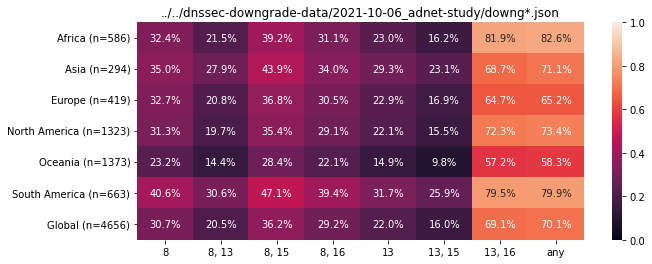

In [32]:
vulnerability_full = vulnerability_region_ds.append(vulnerability_global_ds)
vulnerability_full = vulnerability_full.join(
    vulnerability_region_some_ds.append(
        pd.DataFrame([{'any': vulnerability_global_some_ds}], index=[vulnerability_global_ds.index[0]])
    )
)

f, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    vulnerability_full.astype(float),
    annot=True,
    fmt='.1%',
    ax=ax,
    vmin=0,
    vmax=1,    
)
plt.title(data_file_pattern)

vulnerability_full.style.format(lambda v: f"{v:.1%}")

### Add DS Prevalence

In [33]:
# TODO replace with Elias' data
# values taken from Crawler Tranco
tranco_ds_distribution = {(1,): 4,
 (3,): 1,
 (5,): 882,
 (5, 7): 2,
 (5, 7, 8): 1,
 (5, 8): 20,
 (5, 10): 2,
 (5, 12): 1,
 (5, 13): 7,
 (7,): 1472,
 (7, 8): 8,
 (7, 8, 13, 14): 1,
 (7, 10): 1,
 (7, 13): 9,
 (8,): 21963,
 (8, 10): 5,
 (8, 13): 23,
 (8, 14): 1,
 (10,): 710,
 (10, 13): 2,
 (10, 14): 1,
 (12,): 2,
 (13,): 17862,
 (13, 15): 1,
 (14,): 267,
 (15,): 2}
tranco_ds_total = sum(c for c in tranco_ds_distribution.values())

# values taken from Crawler TLD
tld_ds_distribution = {(5,): 29, (7,): 34, (7, 8): 4, (8,): 1225, (10,): 33, (13,): 45}
tld_ds_total = sum(c for c in tld_ds_distribution.values())

In [34]:
def to_tuple(ds):
    if ds == 'any':
        return None
    return tuple(int(a.strip()) for a in ds.split(','))

vulnerability_full.columns = pd.MultiIndex.from_tuples(
    [(
        #'Prevalence of User Using Vulnerable Resolvers Conditioned on DS Algorithms and World Region', 
        x,
        f"{tranco_ds_distribution.get(to_tuple(x), 0)/tranco_ds_total:.0%}", 
        f"{tld_ds_distribution.get(to_tuple(x), 0)/tld_ds_total:.0%}"
    ) for x in vulnerability_full.columns],
    names=['DS Algorithms', 'Prevalence in Tranco 1M', 'Prevalence in TLDs']
)
vulnerability_full.style.format(lambda v: f"{v:.1%}")

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16",any
Prevalence in Tranco 1M,51%,0%,0%,0%,41%,0%,0%,0%
Prevalence in TLDs,89%,0%,0%,0%,3%,0%,0%,0%
Africa (n=586),32.4%,21.5%,39.2%,31.1%,23.0%,16.2%,81.9%,82.6%
Asia (n=294),35.0%,27.9%,43.9%,34.0%,29.3%,23.1%,68.7%,71.1%
Europe (n=419),32.7%,20.8%,36.8%,30.5%,22.9%,16.9%,64.7%,65.2%
North America (n=1323),31.3%,19.7%,35.4%,29.1%,22.1%,15.5%,72.3%,73.4%
Oceania (n=1373),23.2%,14.4%,28.4%,22.1%,14.9%,9.8%,57.2%,58.3%
South America (n=663),40.6%,30.6%,47.1%,39.4%,31.7%,25.9%,79.5%,79.9%
Global (n=4656),30.7%,20.5%,36.2%,29.2%,22.0%,16.0%,69.1%,70.1%


In [35]:
print(vulnerability_full.to_latex(index=True, float_format=lambda val: f"{val:.1%}", escape=True, na_rep='', column_format="l" + (len(vulnerability_full.keys()) + 1) * "r"))

\begin{tabular}{lrrrrrrrrr}
\toprule
DS Algorithms &     8 & 8, 13 & 8, 15 & 8, 16 &    13 & 13, 15 & 13, 16 &   any \\
Prevalence in Tranco 1M &   51\% &    0\% &    0\% &    0\% &   41\% &     0\% &     0\% &    0\% \\
Prevalence in TLDs &   89\% &    0\% &    0\% &    0\% &    3\% &     0\% &     0\% &    0\% \\
\midrule
Africa (n=586)         & 32.4\% & 21.5\% & 39.2\% & 31.1\% & 23.0\% &  16.2\% &  81.9\% & 82.6\% \\
Asia (n=294)           & 35.0\% & 27.9\% & 43.9\% & 34.0\% & 29.3\% &  23.1\% &  68.7\% & 71.1\% \\
Europe (n=419)         & 32.7\% & 20.8\% & 36.8\% & 30.5\% & 22.9\% &  16.9\% &  64.7\% & 65.2\% \\
North America (n=1323) & 31.3\% & 19.7\% & 35.4\% & 29.1\% & 22.1\% &  15.5\% &  72.3\% & 73.4\% \\
Oceania (n=1373)       & 23.2\% & 14.4\% & 28.4\% & 22.1\% & 14.9\% &   9.8\% &  57.2\% & 58.3\% \\
South America (n=663)  & 40.6\% & 30.6\% & 47.1\% & 39.4\% & 31.7\% &  25.9\% &  79.5\% & 79.9\% \\
Global (n=4656)        & 30.7\% & 20.5\% & 36.2\% & 29.2\% & 22.0\% &  16.

### LaTeX

## Successful Attacks vs DS Config

In [36]:
attack_descriptions = {
    'mitm-ra-ds8-ds13': '... drop RRSIGs using algorithm 8 or 13',
    'mitm-ra-ds8-ds13-ds15': '... drop RRSIGs using algorithm 8, 13, or 15',
    'mitm-rs8-ra': '... rewrite RRSIG algorithm numbers to 8',
    'mitm-rs13-ra': '... rewrite RRSIG algorithm numbers to 13',
    'mitm-rs15-ra': '... rewrite RRSIG algorithm numbers to 15',
    'mitm-rs16-ra': '... rewrite RRSIG algorithm numbers to 16',
}

tests['Attack'] = tests.apply(lambda row: attack_descriptions.get(row['attack'], row['attack']), axis=1)

### Base Table

In [37]:
# aggregate data
vulnerability_attack_ds = tests.groupby(['Attack', 'DS Algorithms', 'token']).agg({
    'vulnerable': unique_value,  # no-op, checking if each combination of attack, ds, token has a unique vulnerability value
}).reset_index().groupby(['Attack', 'DS Algorithms']).agg({
    'vulnerable': 'mean',  # aggregation over tokens
}).reset_index().pivot(index='Attack', columns='DS Algorithms').fillna("")

# order columns nicely
vulnerability_attack_ds.columns = vulnerability_attack_ds.columns.droplevel(0)
vulnerability_attack_ds = vulnerability_attack_ds[natsorted(vulnerability_attack_ds.columns)]

# output
vulnerability_attack_ds.style.format(lambda v: f"{v:.1%}" if isinstance(v, float) else v)

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16"
Attack,,,,,,,
... drop RRSIGs using algorithm 8 or 13,,,,,,,63.9%
"... drop RRSIGs using algorithm 8, 13, or 15",,,,,,,60.6%
... rewrite RRSIG algorithm numbers to 13,,,35.1%,,,,24.8%
... rewrite RRSIG algorithm numbers to 15,30.0%,,,28.4%,,,28.0%
... rewrite RRSIG algorithm numbers to 16,,19.8%,21.0%,,20.9%,,24.2%
... rewrite RRSIG algorithm numbers to 8,8.0%,8.0%,,6.9%,17.3%,16.0%,17.8%


### "Some DS" Column

In [38]:
vulnerability_attack_some_ds = tests.reset_index().groupby(['Attack', 'token']).agg({
    'vulnerable': any,  # aggregation over the attack and ds
}).reset_index().groupby(['Attack']).agg({
    'vulnerable': 'mean'  # aggregation over the token
})
vulnerability_attack_some_ds.columns = pd.Index(['any'])
vulnerability_attack_some_ds.style.format(lambda v: f"{v:.1%}")

,any
Attack,
... drop RRSIGs using algorithm 8 or 13,63.9%
"... drop RRSIGs using algorithm 8, 13, or 15",60.6%
... rewrite RRSIG algorithm numbers to 13,37.6%
... rewrite RRSIG algorithm numbers to 15,32.6%
... rewrite RRSIG algorithm numbers to 16,26.3%
... rewrite RRSIG algorithm numbers to 8,20.3%


In [39]:
vulnerability_any_attack_ds = vulnerability_global_ds.join(pd.DataFrame([{'any': vulnerability_global_some_ds}], index=[vulnerability_global_ds.index[0]]))
vulnerability_any_attack_ds.index = ['any']

### Full Table

In [40]:
pd.options.display.max_colwidth = 0

In [41]:
vulnerability_full = vulnerability_attack_ds.join(vulnerability_attack_some_ds).append(vulnerability_any_attack_ds)
vulnerability_full.columns = pd.MultiIndex.from_tuples(
    [(
        #'Prevalence of User Using Vulnerable Resolvers Conditioned on DS Algorithms and World Region', 
        x,
        f"{tranco_ds_distribution.get(to_tuple(x), 0)/tranco_ds_total:.0%}", 
        f"{tld_ds_distribution.get(to_tuple(x), 0)/tld_ds_total:.0%}"
    ) for x in vulnerability_full.columns],
    names=['DS Algorithms', 'Prevalence in Tranco 1M', 'Prevalence in TLDs']
)
vulnerability_full.style.format(lambda v: f"{v:.1%}")

print(vulnerability_full.to_latex(index=True, float_format=lambda val: f"{val:.1%}", escape=True, na_rep='', column_format="l" + (len(vulnerability_full.keys()) + 1) * "r"))
vulnerability_full.style.format(lambda v: f"{v:.1%}" if isinstance(v, float) else v)

\begin{tabular}{lrrrrrrrrr}
\toprule
DS Algorithms &     8 & 8, 13 & 8, 15 & 8, 16 &    13 & 13, 15 & 13, 16 &   any \\
Prevalence in Tranco 1M &   51\% &    0\% &    0\% &    0\% &   41\% &     0\% &     0\% &    0\% \\
Prevalence in TLDs &   89\% &    0\% &    0\% &    0\% &    3\% &     0\% &     0\% &    0\% \\
\midrule
... drop RRSIGs using algorithm 8 or 13      &   &   &   &   &   &   & 63.9\% & 63.9\% \\
... drop RRSIGs using algorithm 8, 13, or 15 &   &   &   &   &   &   & 60.6\% & 60.6\% \\
... rewrite RRSIG algorithm numbers to 13    &   &   & 35.1\% &   &   &   & 24.8\% & 37.6\% \\
... rewrite RRSIG algorithm numbers to 15    & 30.0\% &   &   & 28.4\% &   &   & 28.0\% & 32.6\% \\
... rewrite RRSIG algorithm numbers to 16    &   & 19.8\% & 21.0\% &   & 20.9\% &   & 24.2\% & 26.3\% \\
... rewrite RRSIG algorithm numbers to 8     & 8.0\% & 8.0\% &   & 6.9\% & 17.3\% & 16.0\% & 17.8\% & 20.3\% \\
any                                          & 30.7\% & 20.5\% & 36.2\% & 29.2\% &

DS Algorithms,8,"8, 13","8, 15","8, 16",13,"13, 15","13, 16",any
Prevalence in Tranco 1M,51%,0%,0%,0%,41%,0%,0%,0%
Prevalence in TLDs,89%,0%,0%,0%,3%,0%,0%,0%
... drop RRSIGs using algorithm 8 or 13,,,,,,,63.9%,63.9%
"... drop RRSIGs using algorithm 8, 13, or 15",,,,,,,60.6%,60.6%
... rewrite RRSIG algorithm numbers to 13,,,35.1%,,,,24.8%,37.6%
... rewrite RRSIG algorithm numbers to 15,30.0%,,,28.4%,,,28.0%,32.6%
... rewrite RRSIG algorithm numbers to 16,,19.8%,21.0%,,20.9%,,24.2%,26.3%
... rewrite RRSIG algorithm numbers to 8,8.0%,8.0%,,6.9%,17.3%,16.0%,17.8%,20.3%
any,30.7%,20.5%,36.2%,29.2%,22.0%,16.0%,69.1%,70.1%
